#Business understanding
Olist, the largest department store in Brazilian markets, graciously shared this dataset. Olist links small companies all over Brazil to channels with a single contract and no trouble. Those businesses may sell their goods on the Olist Store and have them sent straight to customers through Olist logistics partners. Visit www.olist.com for additional information.

A seller is alerted once a buyer orders a product through Olist Store and is responsible for fulfilling that order. When the consumer receives the product or the projected delivery date approaches, he receives an email with a satisfaction survey where he may rate his purchase experience and leave some remarks.

In this notebook, we are going to answer the following questions:
1.   Where these customers?
2.   How do these cutomers order behave?
3.   How do we target them accordingly with different segements?

#Data understanding
This is a public Brazilian ecommerce dataset of Olist Store orders. From 2016 to 2018, the dataset consists about 100k orders placed on several Brazilian marketplaces. Its capabilities allow you to evaluate an order from a variety of perspectives, including order status, pricing, payment, and freight performance, as well as customer location, product qualities, and customer feedback. A geolocation dataset relating Brazilian zip codes to lat/lng coordinates was also available. This is real business data that has been anonymized, and in the review text, references to the companies and partners have been substituted with the names of Game of Thrones great houses.

# Entity Relational Diagram

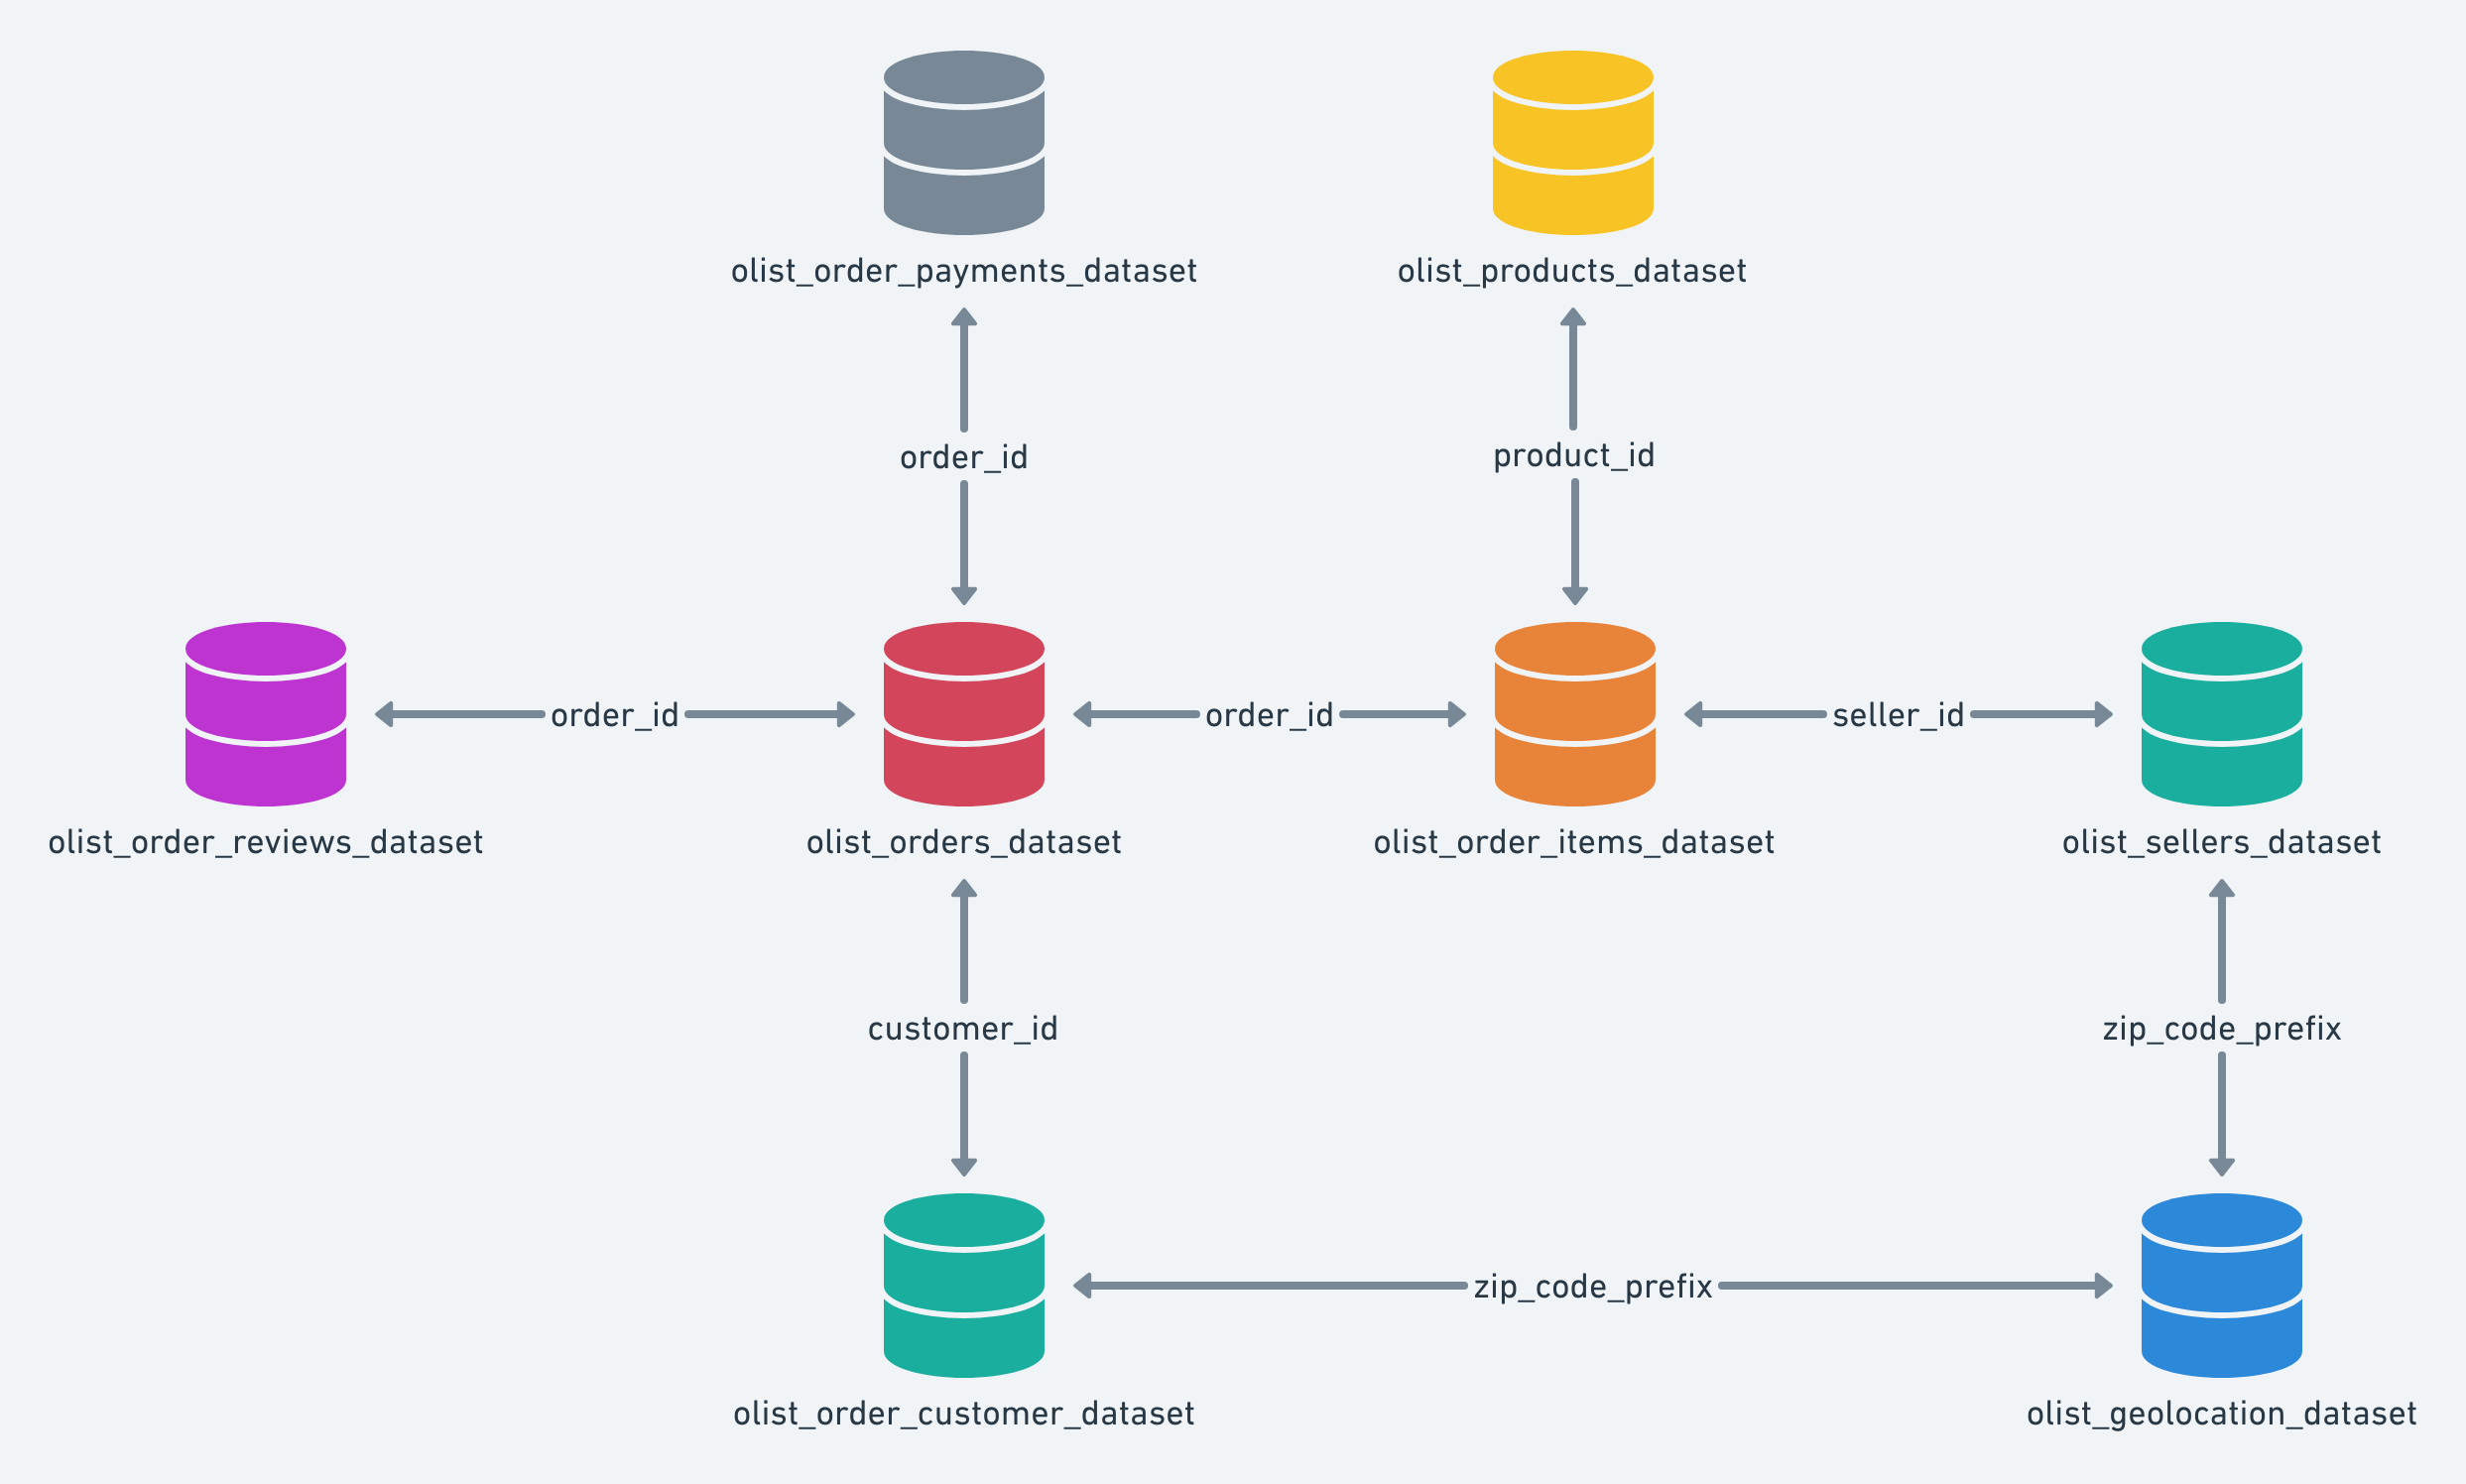

In [2]:
# install unidecode in colab environment
!pip install unidecode

     |████████████████████████████████| 235 kB 5.1 MB/s 


In [3]:
#Import libraries
import numpy as np
import pandas as pd
import datetime
import urllib
import json
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Read needed csv data files only, other datasets can be downloaded at https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_payments_dataset.csv
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

#EDA & Data Preparation

###Payments Dataset

In [5]:
#Taking a peek
payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [6]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


There is no null rows in payments

In [7]:
payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


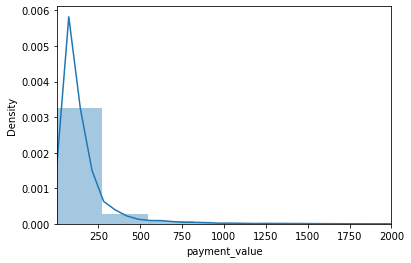

In [8]:
fig, ax = plt.subplots()
sns.distplot(payments["payment_value"], ax=ax)
ax.set_xlim(1, 2000)
plt.show()

The distribution of payments from customers has large value outliers and is highly skewed, not falling into a normal distribution.

In [9]:
payments.groupby('order_id').size().sort_values(ascending=False)

order_id
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
                                    ..
56bd45163229b35ca0ab490c1e3d3233     1
56bc98e6d5b88c2cdb905f2fbec2ca3a     1
56bbc7d92e6e74b8782abbf5ee336a92     1
56bafc014f8ed2f34cfe598592c65fd8     1
fffe41c64501cc87c801fd61db3f6244     1
Length: 99440, dtype: int64

There are orders that got paid with many payment methods, as high as 29, which created multiple rows data with same order_id.

###Customer Dataset

In [10]:
#Take a peek
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [11]:
#Row size
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


There are no null values in customers

In [12]:
#Quick Stats
customers.groupby('customer_city').size().sort_values(ascending=False)

customer_city
sao paulo         15540
rio de janeiro     6882
belo horizonte     2773
brasilia           2131
curitiba           1521
                  ...  
ibiara                1
rio espera            1
rio dos indios        1
rio dos cedros        1
lagoao                1
Length: 4119, dtype: int64

We've got 4119 cities customers and Sao Paulo has the most customers among all with a distinction amount

In [13]:
customers.groupby('customer_unique_id').size().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Length: 96096, dtype: int64

There are dulicates of customer_unique_id


### Geolocation Data Analysis

In [14]:
geolocation.head(10)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP
7,1013,-23.546923,-46.634264,sao paulo,SP
8,1029,-23.543769,-46.634278,sao paulo,SP
9,1011,-23.547640,-46.636032,sao paulo,SP


There are no null values for geolocation

In [15]:
geolocation.isna().mean()

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

As we can see, there are duplicates of the city with similar forms in the names.

In [16]:
geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

Taking a look on the geolocation state distribution of cutomers.

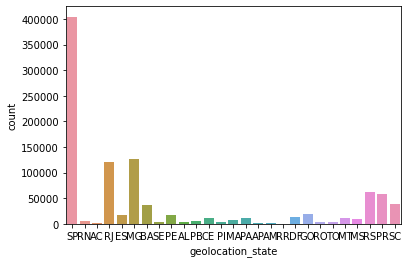

In [17]:
fig, ax = plt.subplots()
sns.countplot(x="geolocation_state", data=geolocation, ax=ax)

In [18]:
def neat_form(column):
    column_space = ' '.join(column.split())
    return unidecode.unidecode(column_space.lower())

In [19]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(neat_form)

In [20]:
geolocation.groupby('geolocation_zip_code_prefix').size().sort_values(ascending=True)

geolocation_zip_code_prefix
11374       1
13176       1
63103       1
63042       1
63012       1
         ... 
11680     879
35500     907
38400     965
24230    1102
24220    1146
Length: 19015, dtype: int64

In [21]:
geolocation[geolocation['geolocation_zip_code_prefix'] == 24220].head()    

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
470805,24220,-22.905817,-43.106989,niteroi,RJ
470811,24220,-22.902306,-43.112545,niteroi,RJ
470812,24220,-22.904567,-43.110491,niteroi,RJ
470820,24220,-22.902575,-43.109192,niteroi,RJ
470821,24220,-22.907500,-43.106170,niteroi,RJ


In [22]:
other_state_geolocation = geolocation.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)
geolocation_silver = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')
customers_silver = customers.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

In [23]:
def plot_brasil_map(data):
    brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(15,15), alpha=1,s=1,c='green')
    plt.axis('off')
    plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
    plt.show()


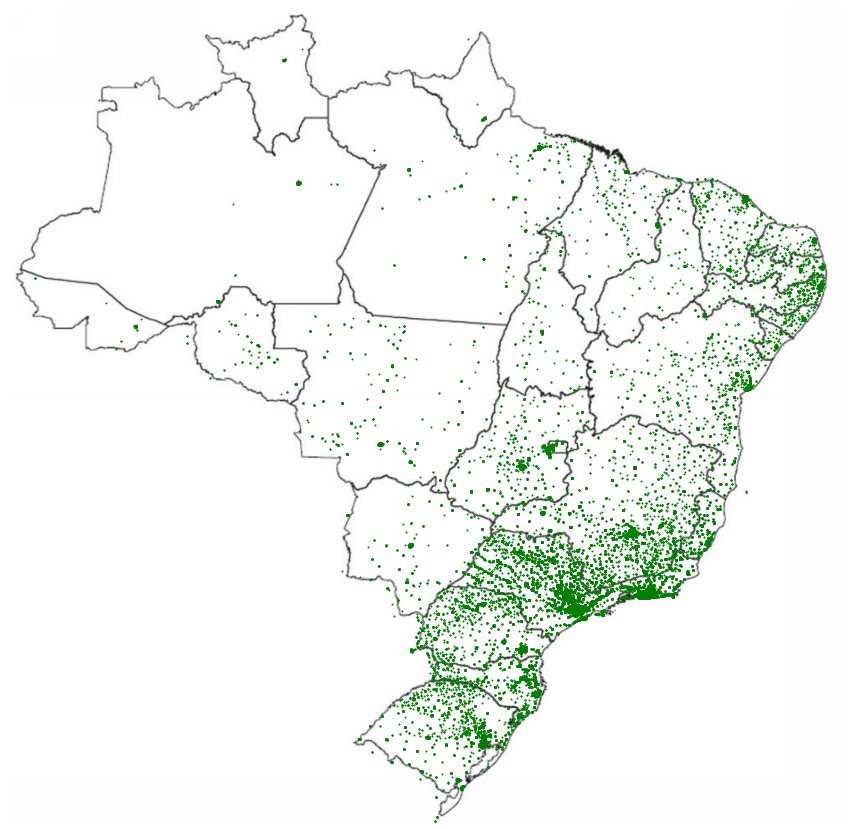

In [24]:
plot_brasil_map(customers_silver.drop_duplicates(subset='customer_unique_id'))

## Q1. Where these customers?

The southeast and south of the nation have more clients. In addition, cities with capitals (Sa Paulo, Rio de Janeiro, Porto Alegre, and others) have more clients. This map shows overall where customers are and how the different density of different locations distribute. Now, the first question we listed has been answered. The company can now see where the customers are coming from in a geolocation sense of thinking. The management level can decide either to expand business to those areas of lower desity of cutomers or put more efforts into focusing on those existing high-desity cities for more valuable cutomsers.

<a id='orders'></a>
## Orders

In [25]:
#Taking a peek
order_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
order_items.isna().mean()

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

No null values for order_items.

In [27]:
order_items.groupby('order_id').size().sort_values(ascending=False)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Length: 98666, dtype: int64

Since we have orders with more than one product, we want to sum the price and the shipping value and get the max value of the shipping_limit_date for analysis later on.

In [28]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()

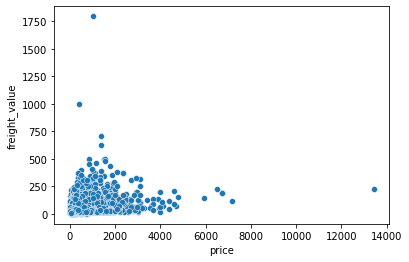

In [29]:
sns.scatterplot(x='price',y='freight_value',data=order_items_silver)

There are some outliers.

In [30]:
order_items_silver.describe()

,price,freight_value
count,98666.000000,98666.000000
mean,137.754076,22.823562
std,210.645145,21.650909
min,0.850000,0.000000
25%,45.900000,13.850000
50%,86.900000,17.170000
75%,149.900000,24.040000
max,13440.000000,1794.960000


In [31]:
percentil_freight_value = order_items_silver['freight_value'].quantile(0.99)
order_items_silver = order_items_silver[(order_items_silver['price'] <= 5000) & (order_items_silver['freight_value'] <= percentil_freight_value)]

Remove orders with a price > 5000 and for the freight value we used logic as a value that is far away from 99% percentile

In [32]:
order_items_silver.describe()

,price,freight_value
count,97679.000000,97679.000000
mean,132.046700,21.423227
std,185.015685,14.133667
min,0.850000,0.000000
25%,45.900000,13.790000
50%,85.000000,17.070000
75%,149.900000,23.700000
max,4690.000000,104.980000


In [33]:
order_items_silver

,order_id,price,freight_value,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,2017-05-03 11:05:13
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,2018-01-18 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,2018-08-15 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,2017-02-13 13:57:51
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,2018-05-02 04:11:01
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,2018-07-20 04:31:48
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,2017-10-30 17:14:25
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,2017-08-21 00:04:32


In [34]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [35]:
columns_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in columns_timestamp:
    orders[column] = pd.to_datetime(orders[column])

In [36]:
orders['diff_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days

In [37]:
orders.groupby(orders['diff_delivery_days'] < 0).size()

diff_delivery_days
False    91614
True      7827
dtype: int64

count    96476.000000
mean        10.876881
std         10.183854
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: diff_delivery_days, dtype: float64


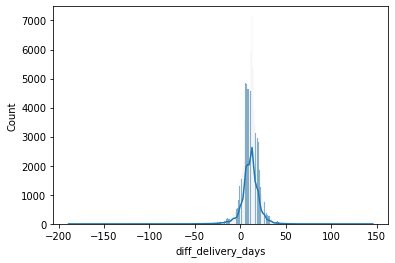

In [38]:
print(orders['diff_delivery_days'].describe())
sns.histplot(x='diff_delivery_days', data=orders, kde=True)

The estimated delivery and the actual delivery difference is around 10 days, which is not ideal for e-commerce. There has to be a lot of room to improve on that.

In [39]:
orders[(orders['diff_delivery_days'] > min(orders['diff_delivery_days'])) & (orders['diff_delivery_days'] < max(orders['diff_delivery_days'])) ]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,5.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,17.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,12.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9.0
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,10.0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,5.0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,20.0


We will remove the max and min value of difference since that's too skewed for this dataset.


In [40]:
orders_silver = orders.merge(order_items_silver,on='order_id',how='inner')

In [41]:
def plot_ts_decompose(decompose,figsize=(12,8)):
    fig, ax = plt.subplots(4,1,figsize=figsize)
    sns.lineplot(data=decompose.observed,x=decompose.observed.index,y=decompose.observed,ax=ax[0])
    sns.lineplot(data=decompose.trend,x=decompose.trend.index,y=decompose.trend,ax=ax[1])
    sns.lineplot(data=decompose.seasonal,x=decompose.seasonal.index,y=decompose.seasonal,ax=ax[2])
    sns.lineplot(data=decompose.resid,x=decompose.resid.index,y=decompose.resid,ax=ax[3])
    plt.tight_layout()

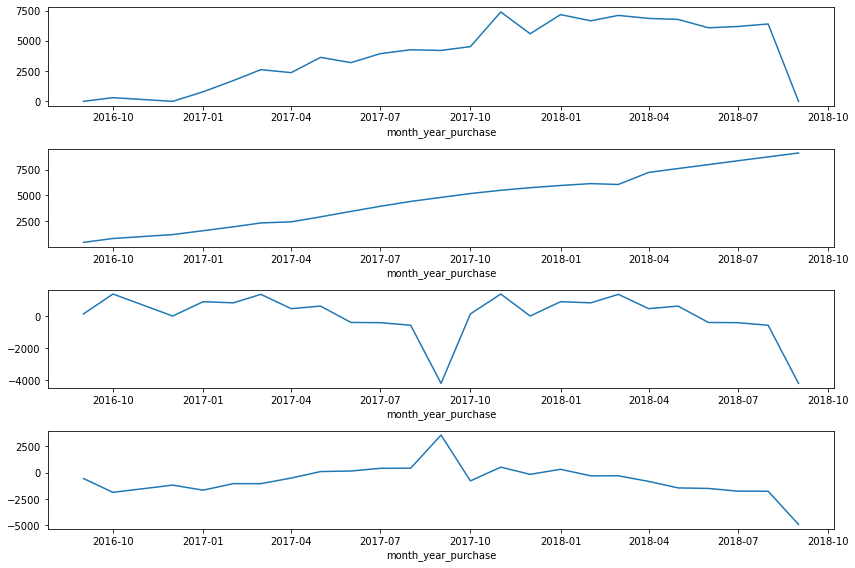

In [ ]:
orders_silver['month_year_purchase'] = orders_silver['order_purchase_timestamp'].dt.to_period('M')
order_purchase_timestamp = orders_silver.groupby('month_year_purchase').size()
order_purchase_timestamp.index = order_purchase_timestamp.index.astype('datetime64[ns]')

decompose = seasonal_decompose(order_purchase_timestamp,model='additive',freq=12, extrapolate_trend=12)
plot_ts_decompose(decompose)

As we can see, there is a seasonality in the series in which in the months of December there is a drop in the purchase of products and in the months of January, March, and May there is an increase. Other fact the series is a trend to incresing.

In [42]:
orders_customers = customers.merge(orders_silver, on='customer_id', how='inner')

In [43]:
max_date = max(orders_customers['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [44]:
rfm_data = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

0.03034247735162137
count    94488.000000
mean         1.033771
std          0.210110
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64


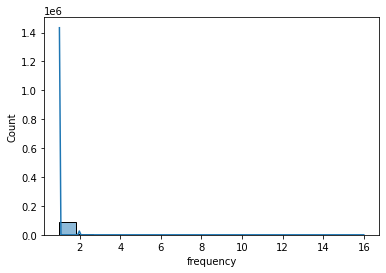

In [45]:
print(rfm_data[rfm_data['frequency']>1].shape[0] / rfm_data.shape[0])
print(rfm_data['frequency'].describe())
sns.histplot(x='frequency', data=rfm_data, kde=True)

count    94488.000000
mean       136.506113
std        190.946953
min          0.850000
25%         47.000000
50%         89.000000
75%        150.000000
max       4690.000000
Name: monetary, dtype: float64


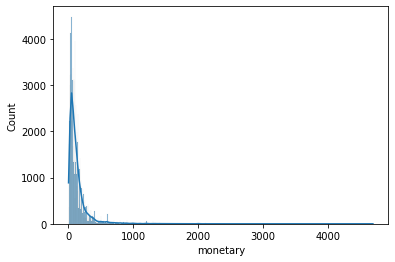

In [46]:
print(rfm_data['monetary'].describe())
sns.histplot(x='monetary', data=rfm_data, kde=True)

As we can see the 25% of customers have a recency of 3.9 months with an average of 8 months. With a purchase frequency equivalent to 1 and with this recency this indicates that customers make very specific purchases.

count    94488.000000
mean       243.851198
std        153.165787
min          1.000000
25%        120.000000
50%        224.000000
75%        353.000000
max        729.000000
Name: recency, dtype: float64


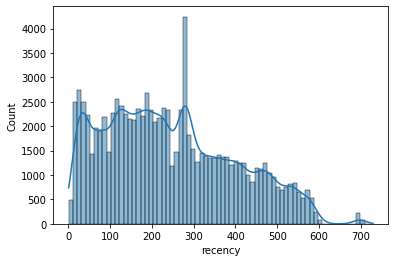

In [47]:
print(rfm_data['recency'].describe())
sns.histplot(x='recency', data=rfm_data, kde=True)

## Q2. How do these cutomers order behave?

There is a seasonal trend in goods purchases, with a reduction in December and an increase in January, March, and May. Only 3% of customers purchased several items. The average monetary consumer spends 136 dollars, with 75% of customers spending less than 150 dollars and the highest spending 4690 dollars. The 25% of clients had a recency of 3.9 months, with an average of 8 months. If a customer's buy frequency is one and their recency is one, they make exceedingly specific purchases.





# RFM Model Definition

As a algorithm the RFM was used, for being an easy-to-understand model.

The term RFM comes from the junction of three acronyms: Recency, Frequency, and Monetarity, seeking to better understand the customer and verify when was his last purchase, how many times he has bought and how much he has spent with the company.

Recency(R) Days since the customer's last purchase
Frequency(F) Number of products bought by the customer
Monetarity(M) Total spent on purchases

Customer Score:

The customer score ranges from 1 to 5, where the higher this number, the better. This score is assigned for each acronym independently:

* The more recent the customer's purchase the higher the Recency (R) score.
* The more purchases the customer makes, the higher the Frequency score (F)
* The more the customer spends on purchases, the higher the score the customer will have Monetarity(M)

This definition of each score can be given through inference, i.e. some business definition or by quintile.

#### **Segmentation by Values:**


| Segment Name               | Range of R values | Range of F and M Average |
|----------------------------|-------------------|--------------------------|
| Champions                  |       4 - 5       |           4 - 5          |
| Loyal Customers            |       2 - 5       |           3 - 5          |
| Potential Loyalist         |       3 - 5       |           1 - 3          |
| New Customers              |       4 - 5       |           0 - 1          |
| Promising                  |       3 - 4       |           0 - 1          |
| Customers Needing Attetion |       2 - 3       |           2 - 3          |
| About to Sleep             |       2 - 3       |           0 - 2          |
| At Risk                    |       0 - 2       |           2 - 5          |
| Can't Lose Them            |       0 - 1       |           4 - 5          |
| Hibernating                |       1 - 2       |           1 - 2          |
| Lost                       |       0 - 2       |           0 - 2          |


First we need to tranform the original data into log form to normalize into 0-5 scales for RFM model

In [48]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

In [49]:
r_labels = k_means_group(rfm_data[['recency']],5,1,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],5,1)
m_labels = k_means_group(rfm_data[['monetary']],5,1)

rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels) 

In [50]:
rfm_data.groupby('R')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
1,11933.0,516.522836,49.824093,450.0,476.0,510.0,547.0,729.0
2,15543.0,383.503957,35.334186,325.0,353.0,383.0,413.0,449.0
3,22579.0,265.345188,31.128486,212.0,236.0,270.0,287.0,324.0
4,24553.0,157.707775,30.919094,106.0,130.0,158.0,185.0,211.0
5,19880.0,52.973592,27.445351,1.0,29.0,49.0,77.0,105.0


In [ ]:
rfm_data.groupby('F')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,91621.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2633.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,215.0,3.130233,0.337345,3.0,3.0,3.0,3.0,4.0
4,18.0,5.722222,1.074055,5.0,5.0,5.0,6.0,9.0
5,1.0,16.000000,NaN,16.0,16.0,16.0,16.0,16.0


In [ ]:
rfm_data.groupby('M')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
1,59699.0,58.291115,29.269077,0.85,32.98,55.0,80.0000,118.33
2,27341.0,178.395047,50.425355,118.39,139.00,165.0,208.0000,310.53
3,5754.0,443.191658,109.776380,310.90,349.90,399.9,524.9000,709.90
4,1398.0,978.586996,215.769246,712.00,799.00,899.7,1129.8275,1535.40
5,296.0,2103.310541,580.200244,1549.00,1699.60,1978.5,2251.2500,4690.00


As we can see, most customers have a recency between 5 to 8 months, only once purchase and skewed distribution on monetary value as well.

Then, we use predefined segment definitions to seperate customers

In [51]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Champions'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyal Customers'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Potential Loyslist'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'New Customers'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promising'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Customer Needing Attention'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'About to Sleep'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'At Risk'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Can't Lose Then"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Hibernating'
    return 'Lost'

In [52]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

Barchart of RFM defined customer segementation

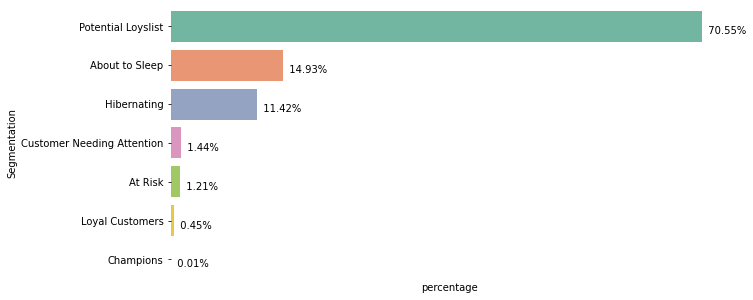

In [54]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette=('Set2'))
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

## Q3.   How do we target them accordingly with different segements?
Since most of our cutomers are potential loyslists, we should be still very optimistic and we should focus on this segement of cutomers. For example, segments like "Cutomer Nedding Attention" and "At Risk" are only about 1% which we should not pay too much attention to. As for a growth strategy, potential loyalist need more stimulus to push them order as a habit. Their recency indicates that we are not repulsive to ordering but just still need more times to turn them into loyal customers. We can add more recommendations and personalization to their experiences to perform A/B testing on our future marketing strategies.